## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

import joblib
import json

from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

### 1. Read dataset

In [2]:
df = pd.read_csv('dataClean.csv')
df.head()

,Date,Mode,Category,Subcategory,Note,Amount,Expense,Currency
0,2015-01-01 08:55:49,Cash,Food,Milk,tea,10.0,Expense,INR
1,2015-01-01 09:12:53,Cash,Transportation,auto,share auto - Place H to Place T base,20.0,Expense,INR
2,2015-01-01 09:29:14,Cash,Transportation,auto,share jeep - Place T to brc,60.0,Expense,INR
3,2015-01-01 09:48:16,Credit Card,Food,Milk,bendys chicken biryani,400.0,Expense,INR
4,2015-01-01 09:57:15,Cash,Transportation,auto,ropeway Place T to and fro,142.0,Expense,INR


### 2. Dtype overview

In [3]:
df.shape

(2302, 8)

Contains 2302 rows and 9 columns

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2302 entries, 0 to 2301
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Date         2302 non-null   object 
 1   Mode         2302 non-null   object 
 2   Category     2302 non-null   object 
 3   Subcategory  2302 non-null   object 
 4   Note         2302 non-null   object 
 5   Amount       2302 non-null   float64
 6   Expense      2302 non-null   object 
 7   Currency     2302 non-null   object 
dtypes: float64(1), object(7)
memory usage: 144.0+ KB


We need to convert `Date` dtype into datetime

In [5]:
df['Category'].value_counts()

Category
Food              1063
Transportation     338
Other              216
Household          182
Utilities          143
Shopping           108
Investment         103
Health              94
Entertainment       33
Education           22
Name: count, dtype: int64

## Preprocessing

### 1. Change `Date` datatype to timestamp

In [6]:
df['Date'] = pd.to_datetime(df['Date'])


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2302 entries, 0 to 2301
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Date         2302 non-null   datetime64[ns]
 1   Mode         2302 non-null   object        
 2   Category     2302 non-null   object        
 3   Subcategory  2302 non-null   object        
 4   Note         2302 non-null   object        
 5   Amount       2302 non-null   float64       
 6   Expense      2302 non-null   object        
 7   Currency     2302 non-null   object        
dtypes: datetime64[ns](1), float64(1), object(6)
memory usage: 144.0+ KB


### 2. Check missing value and duplicate

In [8]:
print('Missing value(s): ')  
print(df.isnull().sum())
print('=====' * 5)
print(f'Duplicate value(s): ', df.duplicated().sum())

Missing value(s): 
Date           0
Mode           0
Category       0
Subcategory    0
Note           0
Amount         0
Expense        0
Currency       0
dtype: int64
Duplicate value(s):  0


There are no missing values and duplication

### 3. Drop columns `Note` and `Currency`

In [9]:
# Drop irrelevant columns
df = df.drop(columns=['Note', 'Currency'])

### 4. Aggregate `Date` into `year`, `month`, `day`, and `dayofweek`

In [10]:
# Break the 'Date' column into year, month, day, day of week features
df['year'] = df['Date'].dt.year
df['month'] = df['Date'].dt.month
df['day'] = df['Date'].dt.day
df['dayofweek'] = df['Date'].dt.dayofweek  #(0 = Monday, 6 = Sunday)

# Drop 'Date' column after breaking it into year, month, day, day of week features
df = df.drop(columns=['Date'])

### 5. Convert INR into IDR

We just convert it based on nowdays currency rate

1 INR = 188.8 Rupiah (per 26 Nov 2024)

Then, we rounded to **200 Rupiah**

Source: **[Google Finance](https://www.google.com/finance/quote/INR-IDR?sa=X&ved=2ahUKEwj_gK6vrfmJAxUC3jgGHRSEHNAQmY0JegQIDRAu)**

In [11]:
df['Amount'].head()

0     10.0
1     20.0
2     60.0
3    400.0
4    142.0
Name: Amount, dtype: float64

In [12]:
# Convert INR to IDR
df['Amount'] = df['Amount'] * 200

In [13]:
df['Amount'].head()

0     2000.0
1     4000.0
2    12000.0
3    80000.0
4    28400.0
Name: Amount, dtype: float64

### 6. Change `Expense` column into numerical column

Because the value of the `Expense` just a string 'Expense'. Then it will be converted to numerical column

In [14]:
# Change all the values into 1
df['Expense'] = 1

### 7. Check distribution for outliers

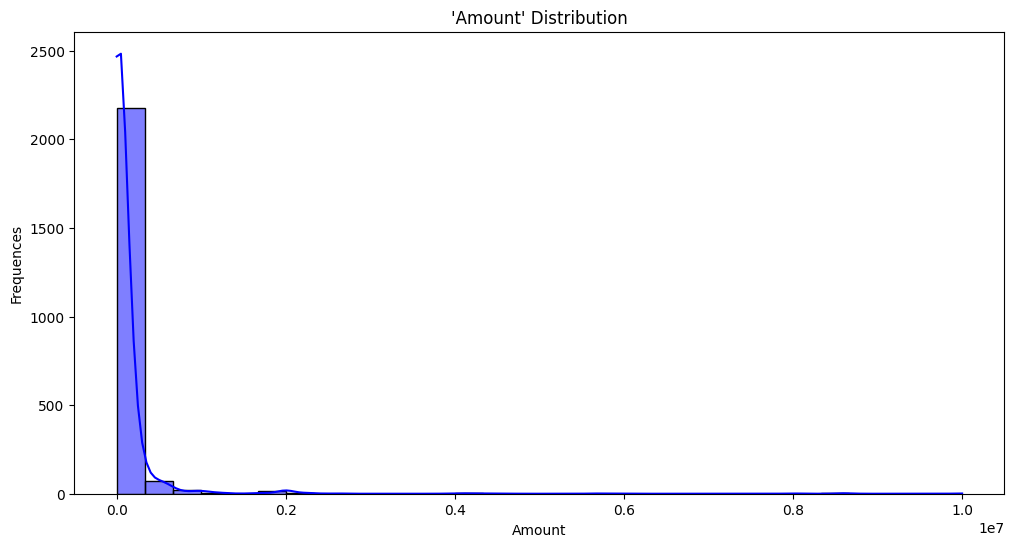

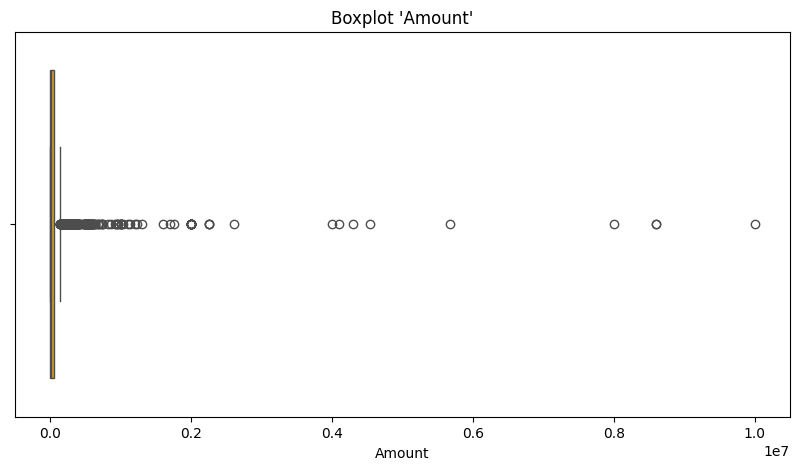

Total Outliers (Z-Score > 3): 30
Index Outliers: [  63   69  144  212  335  337  338  339  340  342  344  345  349  350
  353  356  442  537  563  598  742  795 1130 1166 1440 1491 1559 1582
 1814 1865]
Outliers Value: [ 2000000.  2000000.  2000000.  1605800.  2000000.  2000000.  2000000.
  2000000.  2000000.  2000000.  2000000.  2000000.  2000000.  2000000.
  8000000.  2000000.  2257200.  2257200.  2257200.  4100000.  1700000.
  1765000.  4000000.  8600000.  4540000.  5680000. 10000000.  8600000.
  4300000.  2610000.]

Statisric descriptive 'Amount':
count    2.302000e+03
mean     1.087293e+05
std      4.790565e+05
min      4.000000e+02
25%      6.000000e+03
50%      1.600000e+04
75%      5.895000e+04
max      1.000000e+07
Name: Amount, dtype: float64


In [15]:
from scipy.stats import zscore

# Distribution 'Amount'
plt.figure(figsize=(12, 6))
sns.histplot(df['Amount'], kde=True, bins=30, color='blue')
plt.title("'Amount' Distribution")
plt.xlabel("Amount")
plt.ylabel("Frequences")
plt.show()

# Boxplot to detect outliers
plt.figure(figsize=(10, 5))
sns.boxplot(x=df['Amount'], color='orange')
plt.title("Boxplot 'Amount'")
plt.xlabel("Amount")
plt.show()

# Detect outliers with Z-Score
z_scores = zscore(df['Amount'])
outliers = np.where(np.abs(z_scores) > 3)[0]  # Threshold = 3
print(f"Total Outliers (Z-Score > 3): {len(outliers)}")

# Index and its value of outliers
print("Index Outliers:", outliers)
print("Outliers Value:", df['Amount'].iloc[outliers].values)

# Describe 'Amount'
print("\nStatisric descriptive 'Amount':")
print(df['Amount'].describe())

## Encoding Column

Encode `Mode`, `Category`, and `Subcategory` (convert categorical columns into numerical)

In [16]:
# Encoding 'Mode'
encoder_mode = OneHotEncoder(sparse_output=False)
encoded_mode = encoder_mode.fit_transform(df[['Mode']])
mode_columns = encoder_mode.get_feature_names_out(['Mode'])

# Encoding 'Category'
encoder_category = OneHotEncoder(sparse_output=False)
encoded_category = encoder_category.fit_transform(df[['Category']])
category_columns = encoder_category.get_feature_names_out(['Category'])

# Encoding 'Subcategory'
encoder_subcategory = OneHotEncoder(sparse_output=False)
encoded_subcategory = encoder_subcategory.fit_transform(df[['Subcategory']])
subcategory_columns = encoder_subcategory.get_feature_names_out(['Subcategory'])

# Concatenate all encoded results into one df
encoded_df = pd.DataFrame(
    np.hstack([encoded_mode, encoded_category, encoded_subcategory]),
    columns=np.concatenate([mode_columns, category_columns, subcategory_columns])
)

# Concatenate the encoded results with original df
df = pd.concat([df.reset_index(drop=True), encoded_df.reset_index(drop=True)], axis=1)

# Drop original encoded columns
df = df.drop(['Mode', 'Category', 'Subcategory'], axis=1)

# Show encoded results
df.head()


,Amount,Expense,year,month,day,dayofweek,Mode_CUB - online payment,Mode_Cash,Mode_Credit Card,Mode_Debit Card,...,Subcategory_gift,Subcategory_grooming,Subcategory_home decor,Subcategory_makeup,Subcategory_medicine,Subcategory_misc,Subcategory_ropeway,Subcategory_snacks,Subcategory_train,Subcategory_vegetables
0,2000.0,1,2015,1,1,3,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,4000.0,1,2015,1,1,3,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,12000.0,1,2015,1,1,3,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,80000.0,1,2015,1,1,3,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,28400.0,1,2015,1,1,3,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2302 entries, 0 to 2301
Columns: 133 entries, Amount to Subcategory_vegetables
dtypes: float64(128), int32(4), int64(1)
memory usage: 2.3 MB


## Normalization

### 1. Normalize `Amount`

In [18]:
# Normalize data
scaler = MinMaxScaler()
df['Amount'] = scaler.fit_transform(df[['Amount']])

# Save scaler
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

Only normalize `Amount` and not `Expense` column because `Expense`'s value already 1

### 2. Sorting data based on the time

In [19]:
# year, month, day
df = df.sort_values(by=['year', 'month', 'day']).reset_index(drop=True)
df

,Amount,Expense,year,month,day,dayofweek,Mode_CUB - online payment,Mode_Cash,Mode_Credit Card,Mode_Debit Card,...,Subcategory_gift,Subcategory_grooming,Subcategory_home decor,Subcategory_makeup,Subcategory_medicine,Subcategory_misc,Subcategory_ropeway,Subcategory_snacks,Subcategory_train,Subcategory_vegetables
0,0.00016,1,2015,1,1,3,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.00036,1,2015,1,1,3,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.00116,1,2015,1,1,3,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.00796,1,2015,1,1,3,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.00280,1,2015,1,1,3,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2297,0.00130,1,2022,3,1,1,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2298,0.00056,1,2022,3,1,1,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2299,0.00152,1,2022,3,1,1,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2300,0.00596,1,2022,3,2,2,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Train-test-validation split

We use split ratio 70:15:15 for training, validation, and testing  

In [20]:
# 70% training, 15% validation, 15% test
train_size = int(len(df) * 0.7)
val_size = int(len(df) * 0.15)

# Split into train, validation, and test
X = df.drop(columns=['Amount'])
y = df['Amount']

# Train set
X_train = X[:train_size]
y_train = y[:train_size]

# Validation set
X_val = X[train_size:train_size+val_size]
y_val = y[train_size:train_size+val_size]

# Test set
X_test = X[train_size+val_size:]
y_test = y[train_size+val_size:]

# Shape of split sets
print("Train Set Size:", X_train.shape)
print("Validation Set Size:", X_val.shape)
print("Test Set Size:", X_test.shape)

# Periode data
print("\nTrain Periode:", 
      f"from {X_train['year'].iloc[0]}-{X_train['month'].iloc[0]}-{X_train['day'].iloc[0]}",
      f"until {X_train['year'].iloc[-1]}-{X_train['month'].iloc[-1]}-{X_train['day'].iloc[-1]}")
print("Validation Periode:", 
      f"from {X_val['year'].iloc[0]}-{X_val['month'].iloc[0]}-{X_val['day'].iloc[0]}",
      f"until {X_val['year'].iloc[-1]}-{X_val['month'].iloc[-1]}-{X_val['day'].iloc[-1]}")
print("Test Periode:", 
      f"from {X_test['year'].iloc[0]}-{X_test['month'].iloc[0]}-{X_test['day'].iloc[0]}",
      f"until {X_test['year'].iloc[-1]}-{X_test['month'].iloc[-1]}-{X_test['day'].iloc[-1]}")

Train Set Size: (1611, 132)
Validation Set Size: (345, 132)
Test Set Size: (346, 132)

Train Periode: from 2015-1-1 until 2018-2-7
Validation Periode: from 2018-2-7 until 2018-8-5
Test Periode: from 2018-8-5 until 2022-3-2


## Sequences

### 1. Sequences Function

Make sequences for time series forecasting with parameter
- X: features
- y: target
- window_size: the day before prediction
- horizon: the next day for prediction

In [21]:
def create_sequences(X, y, window_size=15, horizon=15, stride=1):

    # Array to keep sequences
    X_seq, y_seq = [], []
    
    for i in range(0, len(X) - window_size - horizon + 1, stride):
        # Sequence input
        X_seq.append(X[i:(i + window_size)].values)
        # Target output (horizon for next day)
        y_seq.append(y[i + window_size:i + window_size + horizon].values)
    
    return np.array(X_seq), np.array(y_seq)

### 2. Define Parameters

In this model, we will use the first 15 days for the training process and for the next 15 days used as a prediction output.

In [22]:
WINDOW_SIZE = 15  # First 15 days
HORIZON = 15      # Predict next 15 days

### 3. Create Sequences

In [23]:
# Sequences for training set
X_train_seq, y_train_seq = create_sequences(X_train, y_train, 
                                          window_size=WINDOW_SIZE, 
                                          horizon=HORIZON)

# Sequences for validation set
X_val_seq, y_val_seq = create_sequences(X_val, y_val,
                                      window_size=WINDOW_SIZE,
                                      horizon=HORIZON)

# Sequences for test set
X_test_seq, y_test_seq = create_sequences(X_test, y_test,
                                        window_size=WINDOW_SIZE,
                                        horizon=HORIZON)

# Print shape
print("Shape of X train sequences:", X_train_seq.shape)
print("Shape of y train sequences:", y_train_seq.shape)
print("Shape of X validation sequences:", X_val_seq.shape)
print("Shape of y validation sequences:", y_val_seq.shape)
print("Shape of X test sequences:", X_test_seq.shape)
print("Shape of y test sequences:", y_test_seq.shape)

Shape of X train sequences: (1582, 15, 132)
Shape of y train sequences: (1582, 15)
Shape of X validation sequences: (316, 15, 132)
Shape of y validation sequences: (316, 15)
Shape of X test sequences: (317, 15, 132)
Shape of y test sequences: (317, 15)


## Modeling

### 1. Model Function 

In [24]:
def create_model(input_shape):
    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=input_shape),                        # Input layer       
        
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(512, activation='relu',  # Bidirectional LSTM layer
                             return_sequences=True, 
                             )),      
        # tf.keras.layers.Dropout(0.3),                                             # Dropout layer for regularization (avoid overfitting)
        
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, 
                                                           activation='relu', 
                                                           return_sequences=True)),
        # tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.LSTM(128, activation='relu'),
        # tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Dense(128, activation='relu'),      # Dense layer
        tf.keras.layers.Dense(64, activation='relu'),   
        tf.keras.layers.Dense(HORIZON)                      # Output layer for predict HORIZON
    ])
    
    return model

# Model Initialization
input_shape = (WINDOW_SIZE, X_train.shape[1])               # (sequence_length, features)
model = create_model(input_shape)

# Compile model
model.compile(optimizer='adam',
             loss=tf.losses.MeanSquaredError(),
             metrics=['mae'])

# Summary
model.summary()

AttributeError: module 'ml_dtypes' has no attribute 'float8_e3m4'


c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 15, 1024)       │     2,641,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 15, 512)        │     2,623,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 128)            │       328,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 15)             │           975 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,619,343 (21.44 MB)

 Trainable params: 5,619,343 (21.44 MB)

 Non-trainable params: 0 (0.00 B)

In [25]:
# def create_model(input_shape):
#     model = tf.keras.Sequential([
#         # CNN layers
#         tf.keras.layers.Conv1D(filters=512, kernel_size=5, strides=1, padding='causal', activation='relu', input_shape=input_shape),
#         tf.keras.layers.MaxPooling1D(pool_size=2),
#         tf.keras.layers.Conv1D(filters=256, kernel_size=5, strides=1, padding='causal', activation='relu'),
#         tf.keras.layers.MaxPooling1D(pool_size=2),
        
#         #GRU
#         tf.keras.layers.GRU(512, activation='relu', return_sequences=True),
#         tf.keras.layers.GRU(256, activation='relu', return_sequences=True),
#         tf.keras.layers.GRU(128, activation='relu', return_sequences=True),
#         tf.keras.layers.GRU(64, activation='relu'),
        
#         # # LSTM layers
#         # tf.keras.layers.LSTM(256, activation='relu', return_sequences=True),
#         # tf.keras.layers.LSTM(128, activation='relu', return_sequences=True),
#         # tf.keras.layers.LSTM(64, activation='relu'),

#         # Dense layers

#         tf.keras.layers.Dense(256, input_shape=[WINDOW_SIZE], activation='relu'),
#         tf.keras.layers.Dense(128, activation='relu'),
#         tf.keras.layers.Dense(HORIZON)  
#     ])
#     #     tf.keras.layers.InputLayer(input_shape=input_shape),                        # Input layer       
        
#     #     # 
#     #     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(512, activation='elu',  # Bidirectional LSTM layer
#     #                          return_sequences=True, 
#     #                          )),      
#     #     # tf.keras.layers.Dropout(0.3),                                             # Dropout layer for regularization (avoid overfitting)
        
#     #     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, 
#     #                                                        activation='elu', 
#     #                                                        return_sequences=True)),
#     #     # tf.keras.layers.Dropout(0.2),
        
#     #     tf.keras.layers.LSTM(128, activation='relu'),
#     #     # tf.keras.layers.BatchNormalization(),
#     #     # tf.keras.layers.Dropout(0.2),
        
#     #     tf.keras.layers.Dense(128, activation='relu'),      # Dense layer
#     #     tf.keras.layers.Dense(64, activation='relu'),   
#     #     tf.keras.layers.Dense(HORIZON)                      # Output layer for predict HORIZON
#     # ])
    
#     return model

# # Model Initialization
# input_shape = (WINDOW_SIZE, X_train.shape[1])               # (sequence_length, features)

# model = create_model(input_shape)

# # Compile model
# model.compile(optimizer= tf.optimizers.Adam(learning_rate=0.001),
#              loss=tf.losses.MeanSquaredError(),
#              metrics=['mae'])

# # Summary
# model.summary()

In [26]:
# def create_hybrid_model(input_shape):
#     model = tf.keras.Sequential([
#         # Leaky ReLU
#         tf.keras.layers.Conv1D(filters=128, kernel_size=3, activation=tf.keras.layers.LeakyReLU(alpha=0.1), 
#                                input_shape=input_shape),
#         tf.keras.layers.MaxPooling1D(pool_size=2),
#         tf.keras.layers.Dropout(0.3),
        
#         # ELU
#         # biderectional LSTM
#         tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, activation='elu', return_sequences=True)),
#         tf.keras.layers.Dropout(0.3),
        
#         # Parametric ReLU
#         tf.keras.layers.Conv1D(filters=64, kernel_size=3, activation=tf.keras.layers.PReLU(),
#                                input_shape=input_shape),
#         tf.keras.layers.MaxPooling1D(pool_size=2),
#         tf.keras.layers.Dropout(0.3),

#         # tf.keras.layers.Flatten(),
                
#         # ELU LSTM
#         tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, activation='elu')),
#         tf.keras.layers.Dropout(0.2),

#         # Dense layers with ReLU
#         tf.keras.layers.Dense(128, activation='relu'),
#         tf.keras.layers.Dropout(0.4),
        
#         # Dense layers with ReLU
#         tf.keras.layers.Dense(128, activation='relu'),
#         tf.keras.layers.Dropout(0.2),
        
#         tf.keras.layers.Dense(64, activation=tf.keras.layers.LeakyReLU(alpha=0.01)),
#         tf.keras.layers.Dropout(0.2),
        
#         # Output layer
#         tf.keras.layers.Dense(HORIZON)
#     ])
    
#     return model


# # Model Initialization
# input_shape = (WINDOW_SIZE, X_train.shape[1])  # (sequence_length, features)
# model = create_hybrid_model(input_shape)

# # Compile model
# model.compile(optimizer='adam',
#              loss=tf.losses.MeanSquaredError(),
#              metrics=['mae'])

# # Summary
# model.summary()

### 2. Callbacks

In [27]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=30,
    restore_best_weights=True
)

In [28]:
# # Tambahkan learning rate scheduler
# lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
#     monitor='val_loss',
#     factor=0.5,
#     patience=10,
#     min_lr=0.00001
# )

### 3. Traning model

100 epochs and 32 batch_size

In [29]:
history = model.fit(
    X_train_seq, y_train_seq,
    epochs=200,
    batch_size=32,
    validation_data=(X_val_seq, y_val_seq),
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 144ms/step - loss: 137512.7812 - mae: 233.9676 - val_loss: 87717.9375 - val_mae: 230.0063
Epoch 2/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 14s 284ms/step - loss: 83355.0391 - mae: 181.3186 - val_loss: 454.5630 - val_mae: 6.5563
Epoch 3/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 103ms/step - loss: 2299.9280 - mae: 11.4720 - val_loss: 678.6462 - val_mae: 13.3087
Epoch 4/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 102ms/step - loss: 5290.7783 - mae: 16.0649 - val_loss: 0.0013 - val_mae: 0.0187
Epoch 5/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 103ms/step - loss: 0.0101 - mae: 0.0245 - val_loss: 0.0012 - val_mae: 0.0187
Epoch 6/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 110ms/step - loss: 0.0037 - mae: 0.0237 - val_loss: 0.0012 - val_mae: 0.0187
Epoch 7/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 111ms/step - loss: 0.0036 - mae: 0.0232 - val_loss: 0.0012 - val_mae: 0.0187
Epoch 8/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 110ms/step - loss: 0.0032 - mae: 0.0230 - val_loss: 0.0012 - val_mae: 0.0187
Epoch 9/200
50

### 4. Evaluate on test set

In [30]:
test_loss, test_mae = model.evaluate(X_test_seq, y_test_seq, verbose=0)
print(f'\nTest Loss: {test_loss:.4f}')
print(f'Test MAE: {test_mae:.4f}')


Test Loss: 0.0001
Test MAE: 0.0096


## Prediction

In [31]:
train_predictions = model.predict(X_train_seq)  # Predictions for training set
val_predictions = model.predict(X_val_seq)      # Predictions for validation set
test_predictions = model.predict(X_test_seq)    # Predictions for test set

50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step


### 2. Inverse Transform

Inverse transform is the process of returning data that has been normalized to its original scale.

In [32]:
# Inverse transform untuk mendapatkan nilai asli (sebelum scaling)
def inverse_transform_predictions(predictions):
   # Reshape predictions ke 2D array
   predictions_reshaped = predictions.reshape(-1, 1)
   # Inverse transform
   return scaler.inverse_transform(predictions_reshaped).reshape(predictions.shape)

In [33]:
# Inverse transform target dan predictions
# y_train_orig = scaler.inverse_transform(y_train_seq.reshape(-1, 1)).reshape(y_train_seq.shape)
# y_val_orig = scaler.inverse_transform(y_val_seq.reshape(-1, 1)).reshape(y_val_seq.shape)
y_test_orig = scaler.inverse_transform(y_test_seq.reshape(-1, 1)).reshape(y_test_seq.shape)

# train_pred_orig = inverse_transform_predictions(train_predictions)
# val_pred_orig = inverse_transform_predictions(val_predictions)
test_pred_orig = inverse_transform_predictions(test_predictions)

### 3. Visualization

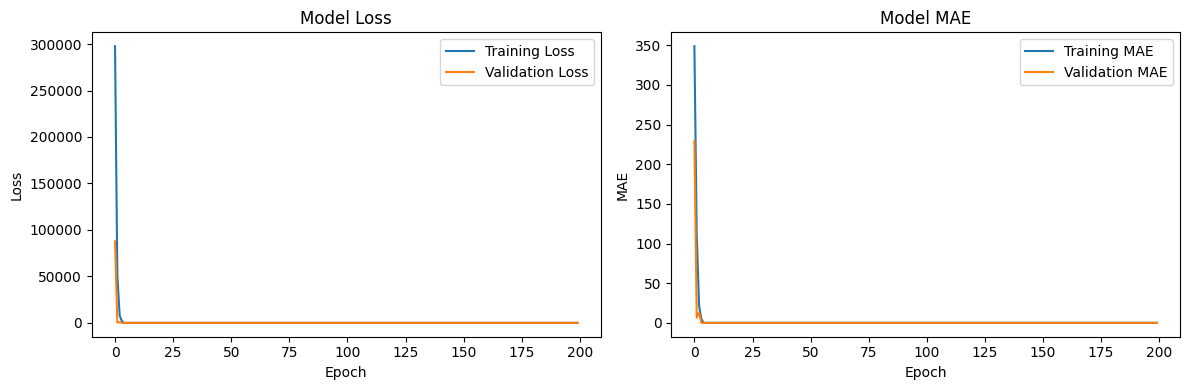

In [34]:
# Training visualization
def plot_training_history(history):
   plt.figure(figsize=(12, 4))
   
   # Plot training & validation loss
   plt.subplot(1, 2, 1)
   plt.plot(history.history['loss'], label='Training Loss')
   plt.plot(history.history['val_loss'], label='Validation Loss')
   plt.title('Model Loss')
   plt.xlabel('Epoch')
   plt.ylabel('Loss')
   plt.legend()
   
   # Plot training & validation MAE
   plt.subplot(1, 2, 2)
   plt.plot(history.history['mae'], label='Training MAE')
   plt.plot(history.history['val_mae'], label='Validation MAE')
   plt.title('Model MAE')
   plt.xlabel('Epoch')
   plt.ylabel('MAE')
   plt.legend()
   
   plt.tight_layout()
   plt.show()

# Print
plot_training_history(history)

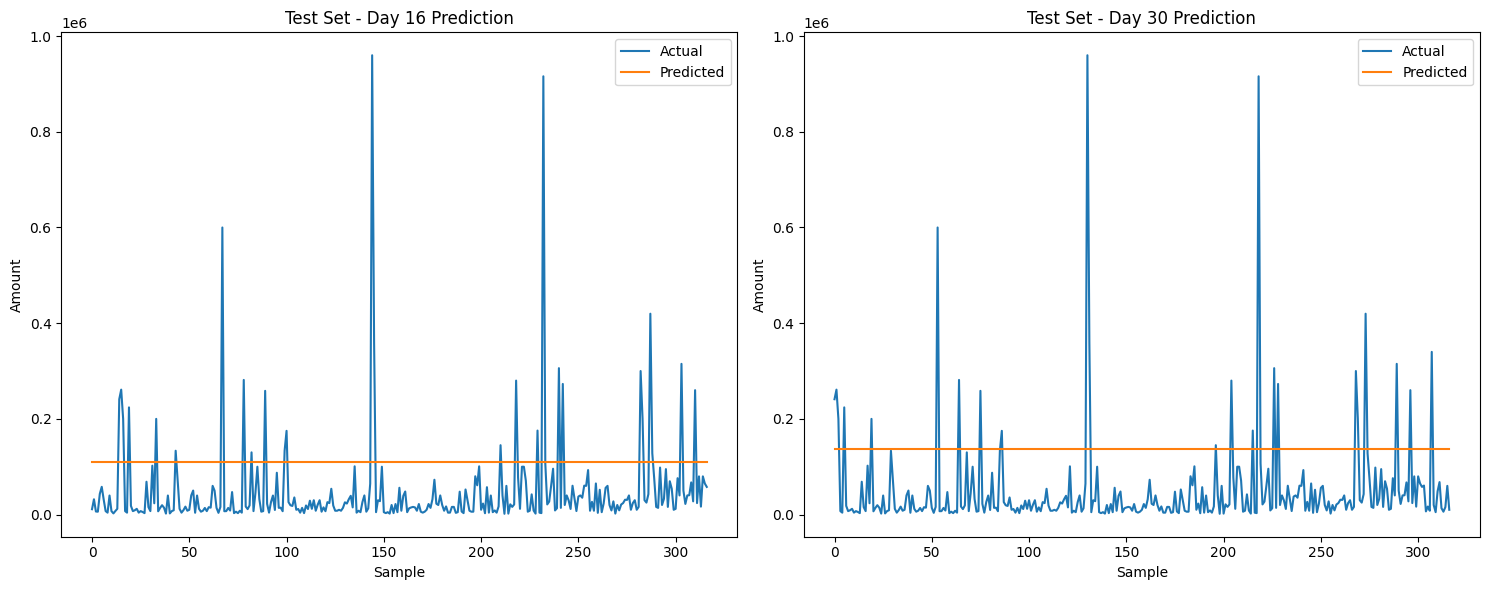

In [35]:
# Prediction vs Actual visualization
def plot_predictions(y_true, y_pred, title):
   plt.figure(figsize=(15, 6))
   
   # First day prediction (day 16)
   plt.subplot(1, 2, 1)
   plt.plot(y_true[:, 0], label='Actual')
   plt.plot(y_pred[:, 0], label='Predicted')
   plt.title(f'{title} - Day 16 Prediction')
   plt.xlabel('Sample')
   plt.ylabel('Amount')
   plt.legend()
   
   # Last day prediction (day 30)
   plt.subplot(1, 2, 2)
   plt.plot(y_true[:, -1], label='Actual')
   plt.plot(y_pred[:, -1], label='Predicted')
   plt.title(f'{title} - Day 30 Prediction')

   plt.xlabel('Sample')
   plt.ylabel('Amount')
   plt.legend()
   
   
   plt.tight_layout()
   plt.show()

# Plot prediksi untuk setiap set
# plot_predictions(y_train_orig, train_pred_orig, 'Training Set')
# plot_predictions(y_val_orig, val_pred_orig, 'Validation Set')
plot_predictions(y_test_orig, test_pred_orig, 'Test Set')

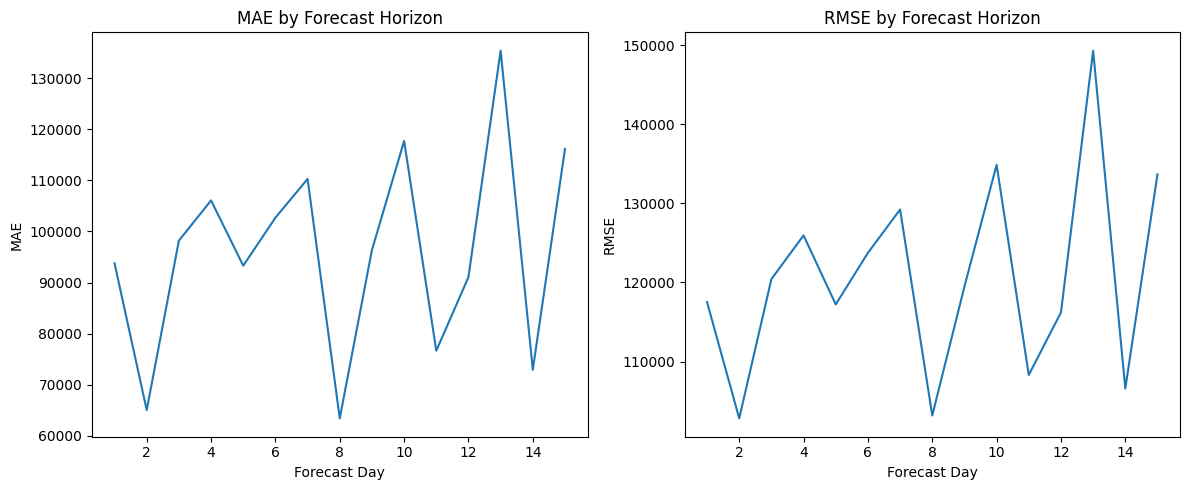

In [36]:
# MAE dan RMSE for every horizon
def calculate_metrics_by_horizon(y_true, y_pred):
   mae_by_horizon = []
   rmse_by_horizon = []
   
   for i in range(HORIZON):
       mae = mean_absolute_error(y_true[:, i], y_pred[:, i])
       rmse = np.sqrt(mean_squared_error(y_true[:, i], y_pred[:, i]))
       mae_by_horizon.append(mae)
       rmse_by_horizon.append(rmse)
   
   return mae_by_horizon, rmse_by_horizon

# Metric for test set
test_mae_by_horizon, test_rmse_by_horizon = calculate_metrics_by_horizon(y_test_orig, test_pred_orig)

# Metric visualization
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, HORIZON + 1), test_mae_by_horizon)
plt.title('MAE by Forecast Horizon')
plt.xlabel('Forecast Day')
plt.ylabel('MAE')

plt.subplot(1, 2, 2)
plt.plot(range(1, HORIZON + 1), test_rmse_by_horizon)
plt.title('RMSE by Forecast Horizon')
plt.xlabel('Forecast Day')
plt.ylabel('RMSE')

plt.tight_layout()
plt.show()

In [37]:
print("\nEvaluatiin Metric Test Set:")
print(f"Average MAE across all horizons: {np.mean(test_mae_by_horizon):.2f}")
print(f"Average RMSE across all horizons: {np.mean(test_rmse_by_horizon):.2f}")
print(f"\nMAE for Day 16 prediction: {test_mae_by_horizon[0]:.2f}")
print(f"MAE for Day 30 prediction: {test_mae_by_horizon[-1]:.2f}")


Evaluatiin Metric Test Set:
Average MAE across all horizons: 95934.07
Average RMSE across all horizons: 120568.79

MAE for Day 16 prediction: 93752.48
MAE for Day 30 prediction: 116175.04


## Save Model

### 1. Architechture + Weights

In [38]:
# .h5
model.save('expense_forecast_model.h5')

# .json
model_json = model.to_json()
with open('model_architecture.json', 'w') as json_file:
    json_file.write(model_json)

# .weights.h5
model.save_weights('model.weights.h5')

### 2. Parameters

In [39]:
model_params = {
    'window_size': WINDOW_SIZE,
    'horizon': HORIZON,
    'input_shape': input_shape[1],
    'feature_columns': list(X_train.columns)
}

with open('model_params.json', 'w') as f:
    json.dump(model_params, f)

print("Model and parameters have been saved!")

Model and parameters have been saved!


## Example Prediction

### 1. Load function model

In [40]:
def load_forecasting_model():
    # Load model
    loaded_model = tf.keras.models.load_model('expense_forecast_model.h5')
    
    # Load parameter
    with open('model_params.json', 'r') as f:
        params = json.load(f)
    
    # Load scaler
    loaded_scaler = joblib.load('scaler.pkl')

    
    return loaded_model, params, loaded_scaler


### 2. Make prediction function

new_data: same format as training data

In [41]:
def make_prediction(model, scaler, new_data, params):

    # Preprocessing new data
    sequences = create_sequences(new_data, 
                               window_size=params['window_size'],
                               horizon=params['horizon'])
    
    # make predict
    predictions = model.predict(sequences)
    
    # Inverse transform predictions
    predictions_orig = scaler.inverse_transform(predictions.reshape(-1, 1))
    
    return predictions_orig.reshape(predictions.shape)

**How to use Model**
1. Load model
loaded_model, params, loaded_scaler = load_forecasting_model()

2. Prepare new data (same columns as training data)
new_data = prepare_new_data()  # Fungsi untuk memproses data baru

3. Predict
predictions = make_prediction(loaded_model, loaded_scaler, new_data, params)

### 3. Preprocessing new data function

input_data: same format as training data

In [42]:
from datetime import timedelta

def prepare_new_data(input_data):
    
    required_columns = ['Date', 'Mode', 'Category', 'Subcategory', 'Amount', 'Note', 'Currency']
    missing_cols = [col for col in required_columns if col not in input_data.columns]
    if missing_cols:
        raise ValueError(f"Input data is missing the following columns: {missing_cols}")

    # Convert datetime
    input_data['Date'] = pd.to_datetime(input_data['Date'])
    
    # Aggregate data
    input_data['year'] = input_data['Date'].dt.year
    input_data['month'] = input_data['Date'].dt.month
    input_data['day'] = input_data['Date'].dt.day
    input_data['dayofweek'] = input_data['Date'].dt.dayofweek
    
    # Drop 'Note','Currency', and 'Date'
    input_data = input_data.drop(columns=['Note', 'Currency', 'Date'])
    
    # One-hot encoding for categorical column ('Mode', 'Category', 'Subcategory'), use encoder same as training
    encoded_mode = encoder_mode.transform(input_data[['Mode']])
    encoded_category = encoder_category.transform(input_data[['Category']])
    encoded_subcategory = encoder_subcategory.transform(input_data[['Subcategory']])
    
    # Concat all encoded results
    encoded_df = pd.DataFrame(
        np.hstack([encoded_mode, encoded_category, encoded_subcategory]),
        columns=np.concatenate([mode_columns, category_columns, subcategory_columns])
    )
    
    # Concat encoded results with original df
    processed_data = pd.concat([
        input_data.drop(['Mode', 'Category', 'Subcategory'], axis=1),
        encoded_df
    ], axis=1)
    
    return processed_data

### 4. Predict function

input_data: df with first 15 days

In [43]:
def predict_future_expenses(input_data, days_to_predict=15):

    # Load model
    loaded_model, params, loaded_scaler = load_forecasting_model()
    
    # Preprocess new data
    processed_data = prepare_new_data(input_data)
    
    # Normalization Amount
    processed_data['Amount'] = loaded_scaler.transform(processed_data[['Amount']])

    # Create sequences for prediction
    X_pred = processed_data.drop(columns=['Amount'])
    X_pred_seq = np.array([X_pred.values[-WINDOW_SIZE:]])
    
    # Predict 
    predictions = loaded_model.predict(X_pred_seq)
    
    # Inverse transform 
    predictions_orig = loaded_scaler.inverse_transform(predictions.reshape(-1, 1))
    
    # Create future dates
    last_date = input_data['Date'].iloc[-1]
    future_dates = [last_date + timedelta(days=i+1) for i in range(days_to_predict)]
    
    predictions_df = pd.DataFrame({
        'Date': future_dates,
        'Predicted_Amount': predictions_orig.flatten()
    })
    
    return predictions_df

### 5. Simulation

In [44]:
# Create dummy data first 15 days
data_15_days = pd.DataFrame({
    'Date': pd.date_range(start='2024-03-01', periods=15),
    'Mode': ['Cash'] * 15,  
    'Category': ['Food'] * 15, 
    'Subcategory': ['Lunch'] * 15,  
    'Note': [''] * 15,
    'Amount': np.round(np.random.uniform(10000, 200000, 15), -3),   # Random amount 10k - 200k
    'Expense': [1] * 15,
    'Currency': ['IDR'] * 15
})

In [45]:
# Print
print("First 15 days:")
print(data_15_days[['Date', 'Amount']])

First 15 days:
         Date    Amount
0  2024-03-01   87000.0
1  2024-03-02   25000.0
2  2024-03-03  189000.0
3  2024-03-04   30000.0
4  2024-03-05  169000.0
5  2024-03-06   39000.0
6  2024-03-07   73000.0
7  2024-03-08  156000.0
8  2024-03-09  128000.0
9  2024-03-10   63000.0
10 2024-03-11  132000.0
11 2024-03-12   14000.0
12 2024-03-13   68000.0
13 2024-03-14  137000.0
14 2024-03-15   84000.0


In [46]:
# Predict
predictions = predict_future_expenses(data_15_days, days_to_predict=15)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 649ms/step


In [47]:
# if prediction < 0, then cahnge it to 0
predictions['Predicted_Amount'] = predictions['Predicted_Amount'].apply(lambda x: max(0, x))

In [48]:
print("\nExpense forecast for next 15 days:")

# predict and round it into 1000
predictions['Predicted_Amount'] = predictions['Predicted_Amount'].apply(lambda x: round(x, -3))
# convert to integer
predictions['Predicted_Amount'] = predictions['Predicted_Amount'].astype(int)
print(predictions.to_string(index=False))



Expense forecast for next 15 days:
      Date  Predicted_Amount
2024-03-16            110000
2024-03-17             74000
2024-03-18            116000
2024-03-19            125000
2024-03-20            110000
2024-03-21            121000
2024-03-22            130000
2024-03-23             70000
2024-03-24            113000
2024-03-25            139000
2024-03-26             88000
2024-03-27            107000
2024-03-28            159000
2024-03-29             84000
2024-03-30            137000


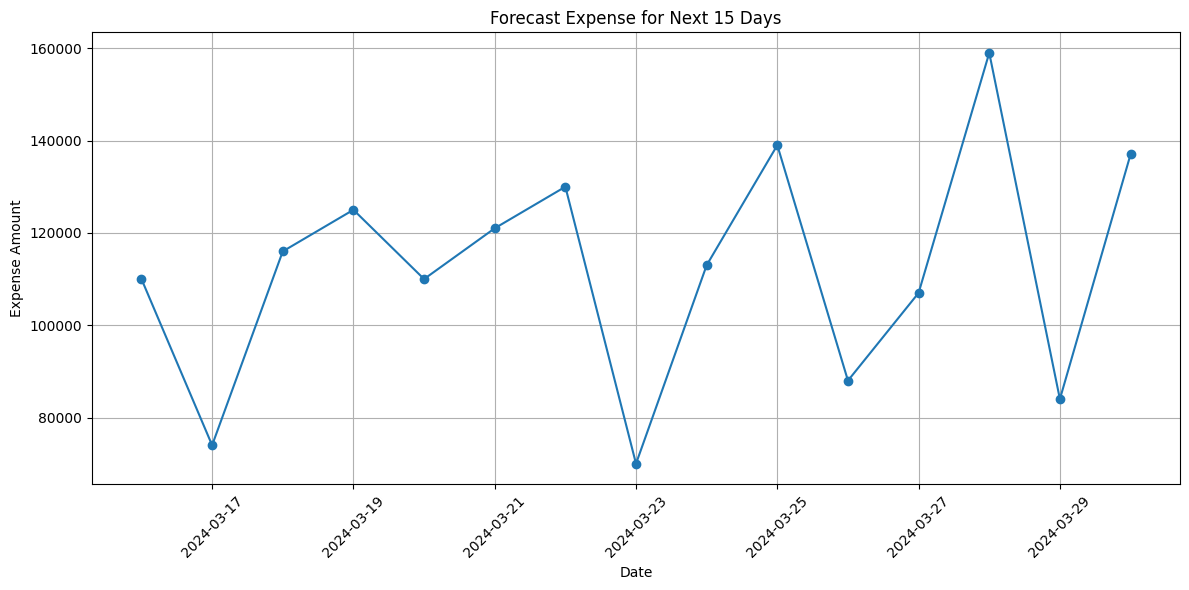

In [49]:
# Visualization
plt.figure(figsize=(12, 6))
plt.plot(predictions['Date'], predictions['Predicted_Amount'], marker='o')
plt.title('Forecast Expense for Next 15 Days')
plt.xlabel('Date')
plt.ylabel('Expense Amount')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

In [50]:
# Statistic
print("\nPrediction Statistic:")
print(f"Average daily expense: {predictions['Predicted_Amount'].mean():.2f}")
print(f"Minimum expense: {predictions['Predicted_Amount'].min():.2f}")
print(f"Maximum expense: {predictions['Predicted_Amount'].max():.2f}")
print(f"Total expense for first 15 days: {data_15_days['Amount'].sum():.2f}")
print(f"Total expense for next 15 days: {predictions['Predicted_Amount'].sum():.2f}")


Prediction Statistic:
Average daily expense: 112200.00
Minimum expense: 70000.00
Maximum expense: 159000.00
Total expense for first 15 days: 1394000.00
Total expense for next 15 days: 1683000.00
